# Credit Default Prediction - Model Training Pipeline

**Objective**: Train XGBoost model to predict credit default

**Pipeline Configuration**:
- Data Split: 70% train / 15% validation / 15% test + 1 month OOT
- Class Imbalance: Class weights
- Model: XGBoost with RandomizedSearchCV
- Features: All features, then feature importance analysis

**Date**: 2025-10-26

## 1. Setup and Imports

In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Spark imports
from pyspark.sql import SparkSession
from pyspark.sql import functions as F

# Scikit-learn imports
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import (
    classification_report, confusion_matrix, 
    roc_auc_score, roc_curve, precision_recall_curve,
    f1_score, precision_score, recall_score, accuracy_score
)

# XGBoost
import xgboost as xgb
from xgboost import XGBClassifier

# Model persistence
import pickle
import joblib

print("All imports successful!")
print(f"XGBoost version: {xgb.__version__}")

In [ ]:
# Initialize Spark
spark = SparkSession.builder \
    .appName("model_training") \
    .master("local[*]") \
    .config("spark.driver.memory", "4g") \
    .getOrCreate()

spark.sparkContext.setLogLevel("ERROR")

print("Spark Session initialized")
print(f"Spark version: {spark.version}")

## 2. Load Feature Store and Label Store

In [ ]:
# Load feature store (Aug 2023 onwards to avoid schema mismatch)
feature_path = '/app/datamart/gold/feature_store/'

print("Loading feature store (Aug 2023 onwards)...")
months_to_load = [
    'gold_feature_store_2023_08_01.parquet',
    'gold_feature_store_2023_09_01.parquet', 
    'gold_feature_store_2023_10_01.parquet',
    'gold_feature_store_2023_11_01.parquet',
    'gold_feature_store_2023_12_01.parquet',
    'gold_feature_store_2024_01_01.parquet',
    'gold_feature_store_2024_02_01.parquet',
    'gold_feature_store_2024_03_01.parquet',
    'gold_feature_store_2024_04_01.parquet',
    'gold_feature_store_2024_05_01.parquet',
    'gold_feature_store_2024_06_01.parquet',
    'gold_feature_store_2024_07_01.parquet',
    'gold_feature_store_2024_08_01.parquet',
    'gold_feature_store_2024_09_01.parquet',
    'gold_feature_store_2024_10_01.parquet',
    'gold_feature_store_2024_11_01.parquet',
    'gold_feature_store_2024_12_01.parquet',
    'gold_feature_store_2025_01_01.parquet'
]

# Load and union all dataframes
df_list = []
for month_file in months_to_load:
    file_path = f'{feature_path}{month_file}'
    df_month = spark.read.parquet(file_path)
    df_list.append(df_month)

df_features_spark = df_list[0]
for df_month in df_list[1:]:
    df_features_spark = df_features_spark.union(df_month)

print(f"Feature store loaded: {df_features_spark.count():,} rows")
print(f"Columns: {len(df_features_spark.columns)}")

In [ ]:
# Load label store
label_path = '/app/datamart/gold/label_store/'

print("Loading label store...")
df_labels_spark = spark.read.parquet(f'{label_path}*/*.parquet')

print(f"Label store loaded: {df_labels_spark.count():,} rows")
print(f"\nLabel store schema:")
df_labels_spark.printSchema()

# Check label distribution
print("\nLabel distribution:")
df_labels_spark.groupBy('label').count().show()

## 3. Merge Feature Store with Label Store

In [ ]:
# Merge feature store with label store
# STRATEGY (following CreditKarma reference):
# 1. Labels are filtered by date range (customers with loans at MOB=6)
# 2. Features are matched to those customers (on Customer_ID only, ignoring snapshot_date)
# 3. Each customer has ONE feature snapshot (from whenever it was captured)
# 4. Each customer may have MULTIPLE labels (multiple loans at different MOB=6 dates)

print("Merging feature store with label store...")
print(f"Features before merge: {df_features_spark.count():,} rows")
print(f"Labels before merge: {df_labels_spark.count():,} rows")

# Convert to Pandas for easier manipulation (following CreditKarma approach)
df_features = df_features_spark.toPandas()
df_labels = df_labels_spark.toPandas()

print(f"\nFeature store: {df_features['Customer_ID'].nunique():,} unique customers")
print(f"Label store: {df_labels['Customer_ID'].nunique():,} unique customers")

# Merge on Customer_ID only (NOT on snapshot_date)
# This matches each customer's single feature snapshot with all their loan labels
df = df_labels.merge(
    df_features,
    on='Customer_ID',
    how='inner',
    suffixes=('_label', '_feature')
)

print(f"\n{'='*80}")
print("MERGE RESULTS")
print(f"{'='*80}")
print(f"Merged records: {len(df):,}")
print(f"Unique customers: {df['Customer_ID'].nunique():,}")

if len(df) == 0:
    print("\n❌ ERROR: Merge produced 0 rows!")
    print("No common Customer_IDs between features and labels")
    raise ValueError("Merge failed - check data alignment")

# Rename snapshot_date columns for clarity
df = df.rename(columns={
    'snapshot_date_label': 'label_date',  # When loan reached MOB=6
    'snapshot_date_feature': 'feature_date'  # When features were captured
})

# Use label_date as the primary snapshot_date for temporal splitting
df['snapshot_date'] = pd.to_datetime(df['label_date'])

print(f"\nDate range (label dates): {df['snapshot_date'].min()} to {df['snapshot_date'].max()}")
print(f"\nLabel distribution:")
print(df['label'].value_counts())
print(f"\nClass imbalance ratio:")
print(df['label'].value_counts(normalize=True))

print(f"\n✅ Merge successful! Using CreditKarma strategy: merge on Customer_ID only")

## 4. Temporal Data Split (70/15/15 + 1 month OOT)

**Strategy**: Time-based split (NOT random) because this is temporal data
- Train: Oldest 70%
- Validation: Next 15%
- Test: Next 15%
- OOT (Out of Time): Most recent 1 month

In [ ]:
# Sort by snapshot_date
df = df.sort_values('snapshot_date').reset_index(drop=True)

# Get unique sorted dates
unique_dates = sorted(df['snapshot_date'].unique())
print(f"Total unique snapshot dates: {len(unique_dates)}")
print(f"Date range: {unique_dates[0]} to {unique_dates[-1]}")

# Reserve last 1 month for OOT
oot_date = unique_dates[-1]
dates_for_split = unique_dates[:-1]  # Exclude last month

print(f"\nOOT month: {oot_date}")
print(f"Dates for train/val/test split: {len(dates_for_split)} months")

# Calculate split indices for remaining dates
n_dates = len(dates_for_split)
train_end_idx = int(n_dates * 0.70)
val_end_idx = int(n_dates * 0.85)

# Get split dates
train_dates = dates_for_split[:train_end_idx]
val_dates = dates_for_split[train_end_idx:val_end_idx]
test_dates = dates_for_split[val_end_idx:]

print(f"\nTrain dates: {len(train_dates)} months ({train_dates[0]} to {train_dates[-1]})")
print(f"Validation dates: {len(val_dates)} months ({val_dates[0]} to {val_dates[-1]})")
print(f"Test dates: {len(test_dates)} months ({test_dates[0]} to {test_dates[-1]})")
print(f"OOT date: 1 month ({oot_date})")

# Create splits
train_df = df[df['snapshot_date'].isin(train_dates)].copy()
val_df = df[df['snapshot_date'].isin(val_dates)].copy()
test_df = df[df['snapshot_date'].isin(test_dates)].copy()
oot_df = df[df['snapshot_date'] == oot_date].copy()

print(f"\n{'='*80}")
print("SPLIT SUMMARY")
print(f"{'='*80}")
print(f"Train: {len(train_df):,} rows ({len(train_df)/len(df)*100:.1f}%)")
print(f"Validation: {len(val_df):,} rows ({len(val_df)/len(df)*100:.1f}%)")
print(f"Test: {len(test_df):,} rows ({len(test_df)/len(df)*100:.1f}%)")
print(f"OOT: {len(oot_df):,} rows ({len(oot_df)/len(df)*100:.1f}%)")
print(f"Total: {len(train_df)+len(val_df)+len(test_df)+len(oot_df):,} rows")

# Check label distribution in each split
print(f"\n{'='*80}")
print("LABEL DISTRIBUTION BY SPLIT")
print(f"{'='*80}")
for name, split_df in [('Train', train_df), ('Validation', val_df), ('Test', test_df), ('OOT', oot_df)]:
    print(f"\n{name}:")
    print(split_df['label'].value_counts())
    print(f"Default rate: {split_df['label'].mean()*100:.2f}%")

## 5. Feature Engineering and Preprocessing

In [ ]:
# Identify feature columns (exclude ID, date, and label)
exclude_cols = ['Customer_ID', 'snapshot_date', 'label', 'last_activity_date']
feature_cols = [col for col in df.columns if col not in exclude_cols]

print(f"Total features: {len(feature_cols)}")
print(f"\nFeature columns:")
print(feature_cols)

# Separate numeric and categorical features
numeric_features = train_df[feature_cols].select_dtypes(include=[np.number]).columns.tolist()
categorical_features = train_df[feature_cols].select_dtypes(include=['object']).columns.tolist()

print(f"\nNumeric features: {len(numeric_features)}")
print(numeric_features)
print(f"\nCategorical features: {len(categorical_features)}")
print(categorical_features)

In [ ]:
# Check for missing values
print("Missing values in training set:")
missing = train_df[feature_cols].isnull().sum()
missing = missing[missing > 0].sort_values(ascending=False)
if len(missing) > 0:
    print(missing)
else:
    print("No missing values!")

In [13]:
# Preprocessing function
def preprocess_data(train, val, test, oot, numeric_features, categorical_features):
    """
    Preprocess data:
    1. Handle missing values
    2. Encode categorical features
    3. Scale numeric features
    
    Returns: X_train, X_val, X_test, X_oot, y_train, y_val, y_test, y_oot, preprocessors
    """
    
    # Make copies
    train_proc = train.copy()
    val_proc = val.copy()
    test_proc = test.copy()
    oot_proc = oot.copy()
    
    # 1. Handle missing values in numeric features (fill with median from training)
    numeric_medians = {}
    for col in numeric_features:
        median_val = train_proc[col].median()
        numeric_medians[col] = median_val
        
        train_proc[col].fillna(median_val, inplace=True)
        val_proc[col].fillna(median_val, inplace=True)
        test_proc[col].fillna(median_val, inplace=True)
        oot_proc[col].fillna(median_val, inplace=True)
    
    # 2. Encode categorical features (Label Encoding)
    label_encoders = {}
    for col in categorical_features:
        le = LabelEncoder()
        
        # Fill missing categorical with 'Unknown'
        train_proc[col].fillna('Unknown', inplace=True)
        val_proc[col].fillna('Unknown', inplace=True)
        test_proc[col].fillna('Unknown', inplace=True)
        oot_proc[col].fillna('Unknown', inplace=True)
        
        # Collect all unique values from all datasets to handle unseen categories
        all_categories = set(train_proc[col].unique())
        all_categories.update(val_proc[col].unique())
        all_categories.update(test_proc[col].unique())
        all_categories.update(oot_proc[col].unique())
        
        # Fit encoder on all unique categories (including 'Unknown' if present)
        le.fit(list(all_categories))
        label_encoders[col] = le
        
        # Transform all splits (now all categories are known)
        train_proc[col] = le.transform(train_proc[col])
        val_proc[col] = le.transform(val_proc[col])
        test_proc[col] = le.transform(test_proc[col])
        oot_proc[col] = le.transform(oot_proc[col])
    
    # 3. Scale numeric features (StandardScaler)
    # NOTE: Tree-based models like XGBoost don't require scaling
    # But we'll do it anyway for consistency
    scaler = StandardScaler()
    
    # Fit on training data
    scaler.fit(train_proc[numeric_features])
    
    # Transform all splits
    train_proc[numeric_features] = scaler.transform(train_proc[numeric_features])
    val_proc[numeric_features] = scaler.transform(val_proc[numeric_features])
    test_proc[numeric_features] = scaler.transform(test_proc[numeric_features])
    oot_proc[numeric_features] = scaler.transform(oot_proc[numeric_features])
    
    # Create X and y
    all_features = numeric_features + categorical_features
    
    X_train = train_proc[all_features]
    X_val = val_proc[all_features]
    X_test = test_proc[all_features]
    X_oot = oot_proc[all_features]
    
    y_train = train_proc['label']
    y_val = val_proc['label']
    y_test = test_proc['label']
    y_oot = oot_proc['label']
    
    # Store preprocessors
    preprocessors = {
        'numeric_medians': numeric_medians,
        'label_encoders': label_encoders,
        'scaler': scaler,
        'feature_names': all_features,
        'numeric_features': numeric_features,
        'categorical_features': categorical_features
    }
    
    return X_train, X_val, X_test, X_oot, y_train, y_val, y_test, y_oot, preprocessors

print("Preprocessing data...")
X_train, X_val, X_test, X_oot, y_train, y_val, y_test, y_oot, preprocessors = preprocess_data(
    train_df, val_df, test_df, oot_df, numeric_features, categorical_features
)

print(f"\nPreprocessing complete!")
print(f"X_train shape: {X_train.shape}")
print(f"X_val shape: {X_val.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"X_oot shape: {X_oot.shape}")

Preprocessing data...

Preprocessing complete!
X_train shape: (3405, 31)
X_val shape: (1024, 31)
X_test shape: (989, 31)
X_oot shape: (505, 31)


## 6. Calculate Class Weights

In [14]:
# Calculate class weights to handle imbalance
from sklearn.utils.class_weight import compute_class_weight

class_weights_array = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)

# Create dictionary for XGBoost
class_weights_dict = {i: weight for i, weight in enumerate(class_weights_array)}

print("Class weights (to handle imbalance):")
print(class_weights_dict)

# Calculate scale_pos_weight for XGBoost (alternative to class weights)
n_neg = (y_train == 0).sum()
n_pos = (y_train == 1).sum()
scale_pos_weight = n_neg / n_pos

print(f"\nScale pos weight: {scale_pos_weight:.2f}")
print(f"  (Ratio of negative to positive samples)")

Class weights (to handle imbalance):
{0: 0.6986048420188756, 1: 1.7587809917355373}

Scale pos weight: 2.52
  (Ratio of negative to positive samples)


## 7. Train Baseline XGBoost Model

In [15]:
# Train baseline XGBoost with default parameters + class weights
print("Training baseline XGBoost model...")

baseline_model = XGBClassifier(
    scale_pos_weight=scale_pos_weight,  # Handle class imbalance
    random_state=42,
    eval_metric='logloss',
    early_stopping_rounds=10,
    n_estimators=100
)

# Train with early stopping on validation set
baseline_model.fit(
    X_train, y_train,
    eval_set=[(X_val, y_val)],
    verbose=False
)

print("Baseline model trained!")
print(f"Best iteration: {baseline_model.best_iteration}")
print(f"Best score: {baseline_model.best_score:.4f}")

Training baseline XGBoost model...
Baseline model trained!
Best iteration: 26
Best score: 0.5410


In [16]:
# Evaluate baseline model
def evaluate_model(model, X, y, dataset_name="Dataset"):
    """
    Evaluate model and print comprehensive metrics
    """
    y_pred = model.predict(X)
    y_pred_proba = model.predict_proba(X)[:, 1]
    
    print(f"\n{'='*80}")
    print(f"{dataset_name.upper()} METRICS")
    print(f"{'='*80}")
    
    # Classification metrics
    print(f"\nAccuracy: {accuracy_score(y, y_pred):.4f}")
    print(f"Precision: {precision_score(y, y_pred):.4f}")
    print(f"Recall: {recall_score(y, y_pred):.4f}")
    print(f"F1-Score: {f1_score(y, y_pred):.4f}")
    print(f"ROC-AUC: {roc_auc_score(y, y_pred_proba):.4f}")
    
    # Confusion matrix
    print(f"\nConfusion Matrix:")
    cm = confusion_matrix(y, y_pred)
    print(cm)
    
    # Classification report
    print(f"\nClassification Report:")
    print(classification_report(y, y_pred))
    
    return y_pred, y_pred_proba

# Evaluate on all datasets
y_train_pred, y_train_proba = evaluate_model(baseline_model, X_train, y_train, "Train")
y_val_pred, y_val_proba = evaluate_model(baseline_model, X_val, y_val, "Validation")
y_test_pred, y_test_proba = evaluate_model(baseline_model, X_test, y_test, "Test")
y_oot_pred, y_oot_proba = evaluate_model(baseline_model, X_oot, y_oot, "OOT")


TRAIN METRICS

Accuracy: 0.9445
Precision: 0.8564
Recall: 0.9669
F1-Score: 0.9083
ROC-AUC: 0.9890

Confusion Matrix:
[[2280  157]
 [  32  936]]

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.94      0.96      2437
           1       0.86      0.97      0.91       968

    accuracy                           0.94      3405
   macro avg       0.92      0.95      0.93      3405
weighted avg       0.95      0.94      0.95      3405


VALIDATION METRICS

Accuracy: 0.7578
Precision: 0.6000
Recall: 0.6000
F1-Score: 0.6000
ROC-AUC: 0.7825

Confusion Matrix:
[[590 124]
 [124 186]]

Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.83      0.83       714
           1       0.60      0.60      0.60       310

    accuracy                           0.76      1024
   macro avg       0.71      0.71      0.71      1024
weighted avg       0.76      0.76      0.76      1024


TEST M

## 8. Hyperparameter Tuning with RandomizedSearchCV

In [17]:
# Define hyperparameter search space
param_distributions = {
    'n_estimators': [100, 200, 300, 500],
    'max_depth': [3, 5, 7, 9, 11],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'subsample': [0.6, 0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.6, 0.7, 0.8, 0.9, 1.0],
    'min_child_weight': [1, 3, 5, 7],
    'gamma': [0, 0.1, 0.2, 0.3, 0.4],
    'reg_alpha': [0, 0.01, 0.1, 1],
    'reg_lambda': [1, 1.5, 2, 3]
}

print("Hyperparameter search space:")
for param, values in param_distributions.items():
    print(f"  {param}: {values}")

print(f"\nTotal possible combinations: {np.prod([len(v) for v in param_distributions.values()]):,}")

Hyperparameter search space:
  n_estimators: [100, 200, 300, 500]
  max_depth: [3, 5, 7, 9, 11]
  learning_rate: [0.01, 0.05, 0.1, 0.2]
  subsample: [0.6, 0.7, 0.8, 0.9, 1.0]
  colsample_bytree: [0.6, 0.7, 0.8, 0.9, 1.0]
  min_child_weight: [1, 3, 5, 7]
  gamma: [0, 0.1, 0.2, 0.3, 0.4]
  reg_alpha: [0, 0.01, 0.1, 1]
  reg_lambda: [1, 1.5, 2, 3]

Total possible combinations: 640,000


In [18]:
# RandomizedSearchCV
print("Starting RandomizedSearchCV...")
print("This may take several minutes...\n")

# Create XGBoost model WITHOUT early_stopping_rounds for CV
# (Early stopping requires eval_set which isn't available during CV)
xgb_model = XGBClassifier(
    scale_pos_weight=scale_pos_weight,
    random_state=42,
    eval_metric='logloss'
    # NOTE: No early_stopping_rounds here - will add after CV
)

# Use StratifiedKFold for cross-validation (maintains class distribution)
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

random_search = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=param_distributions,
    n_iter=50,  # Number of random combinations to try
    cv=cv,
    scoring='roc_auc',
    n_jobs=-1,  # Use all CPU cores
    verbose=2,
    random_state=42
)

# Fit on training data
random_search.fit(X_train, y_train)

print("\n" + "="*80)
print("HYPERPARAMETER TUNING COMPLETE")
print("="*80)
print(f"\nBest ROC-AUC (CV): {random_search.best_score_:.4f}")
print(f"\nBest parameters:")
for param, value in random_search.best_params_.items():
    print(f"  {param}: {value}")

Starting RandomizedSearchCV...
This may take several minutes...

Fitting 3 folds for each of 50 candidates, totalling 150 fits
[CV] END colsample_bytree=0.6, gamma=0.4, learning_rate=0.2, max_depth=3, min_child_weight=3, n_estimators=100, reg_alpha=0.01, reg_lambda=3, subsample=0.9; total time=   0.4s
[CV] END colsample_bytree=0.6, gamma=0.4, learning_rate=0.2, max_depth=3, min_child_weight=3, n_estimators=100, reg_alpha=0.01, reg_lambda=3, subsample=0.9; total time=   0.4s
[CV] END colsample_bytree=0.6, gamma=0.4, learning_rate=0.2, max_depth=3, min_child_weight=3, n_estimators=100, reg_alpha=0.01, reg_lambda=3, subsample=0.9; total time=   0.4s
[CV] END colsample_bytree=0.8, gamma=0.4, learning_rate=0.05, max_depth=3, min_child_weight=7, n_estimators=100, reg_alpha=1, reg_lambda=3, subsample=0.9; total time=   0.4s
[CV] END colsample_bytree=0.8, gamma=0.4, learning_rate=0.05, max_depth=3, min_child_weight=7, n_estimators=100, reg_alpha=1, reg_lambda=3, subsample=0.9; total time=   0.

Exception ignored in: <function ResourceTracker.__del__ at 0x7aceae4719e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/multiprocessing/resource_tracker.py", line 77, in __del__
  File "/usr/local/lib/python3.12/multiprocessing/resource_tracker.py", line 86, in _stop
  File "/usr/local/lib/python3.12/multiprocessing/resource_tracker.py", line 111, in _stop_locked
ChildProcessError: [Errno 10] No child processes
Exception ignored in: <function ResourceTracker.__del__ at 0x71d3ffa399e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/multiprocessing/resource_tracker.py", line 77, in __del__
  File "/usr/local/lib/python3.12/multiprocessing/resource_tracker.py", line 86, in _stop
  File "/usr/local/lib/python3.12/multiprocessing/resource_tracker.py", line 111, in _stop_locked
ChildProcessError: [Errno 10] No child processes
Exception ignored in: <function ResourceTracker.__del__ at 0x7dbd00b319e0>
Traceback (most recent call last):
  File "/usr

In [19]:
# Get best model
best_model = random_search.best_estimator_

# Retrain best model with early stopping on validation set
print("Retraining best model with early stopping on validation set...")

best_model_retrained = XGBClassifier(
    **random_search.best_params_,
    scale_pos_weight=scale_pos_weight,
    random_state=42,
    eval_metric='logloss',
    early_stopping_rounds=10
)

best_model_retrained.fit(
    X_train, y_train,
    eval_set=[(X_val, y_val)],
    verbose=False
)

print(f"Best model retrained!")
print(f"Best iteration: {best_model_retrained.best_iteration}")
print(f"Best score: {best_model_retrained.best_score:.4f}")

Retraining best model with early stopping on validation set...
Best model retrained!
Best iteration: 299
Best score: 0.5281


## 9. Evaluate Final Model on All Datasets

In [20]:
# Evaluate tuned model on all datasets
print("\n" + "="*80)
print("FINAL MODEL EVALUATION")
print("="*80)

y_train_pred_final, y_train_proba_final = evaluate_model(best_model_retrained, X_train, y_train, "Train")
y_val_pred_final, y_val_proba_final = evaluate_model(best_model_retrained, X_val, y_val, "Validation")
y_test_pred_final, y_test_proba_final = evaluate_model(best_model_retrained, X_test, y_test, "Test")
y_oot_pred_final, y_oot_proba_final = evaluate_model(best_model_retrained, X_oot, y_oot, "OOT")


FINAL MODEL EVALUATION

TRAIN METRICS

Accuracy: 0.8872
Precision: 0.7645
Recall: 0.8719
F1-Score: 0.8147
ROC-AUC: 0.9637

Confusion Matrix:
[[2177  260]
 [ 124  844]]

Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.89      0.92      2437
           1       0.76      0.87      0.81       968

    accuracy                           0.89      3405
   macro avg       0.86      0.88      0.87      3405
weighted avg       0.89      0.89      0.89      3405


VALIDATION METRICS

Accuracy: 0.7676
Precision: 0.6111
Recall: 0.6387
F1-Score: 0.6246
ROC-AUC: 0.7924

Confusion Matrix:
[[588 126]
 [112 198]]

Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.82      0.83       714
           1       0.61      0.64      0.62       310

    accuracy                           0.77      1024
   macro avg       0.73      0.73      0.73      1024
weighted avg       0.77      0.77     

In [21]:
# Compare baseline vs tuned model
print("\n" + "="*80)
print("BASELINE vs TUNED MODEL COMPARISON")
print("="*80)

comparison_results = []

for dataset_name, X, y in [
    ('Train', X_train, y_train),
    ('Validation', X_val, y_val),
    ('Test', X_test, y_test),
    ('OOT', X_oot, y_oot)
]:
    # Baseline
    y_pred_base = baseline_model.predict(X)
    y_proba_base = baseline_model.predict_proba(X)[:, 1]
    
    # Tuned
    y_pred_tuned = best_model_retrained.predict(X)
    y_proba_tuned = best_model_retrained.predict_proba(X)[:, 1]
    
    comparison_results.append({
        'Dataset': dataset_name,
        'Baseline_AUC': roc_auc_score(y, y_proba_base),
        'Tuned_AUC': roc_auc_score(y, y_proba_tuned),
        'Baseline_F1': f1_score(y, y_pred_base),
        'Tuned_F1': f1_score(y, y_pred_tuned),
        'Baseline_Precision': precision_score(y, y_pred_base),
        'Tuned_Precision': precision_score(y, y_pred_tuned),
        'Baseline_Recall': recall_score(y, y_pred_base),
        'Tuned_Recall': recall_score(y, y_pred_tuned)
    })

comparison_df = pd.DataFrame(comparison_results)
print(comparison_df.to_string(index=False))

# Calculate improvements
print(f"\nAverage AUC improvement: {(comparison_df['Tuned_AUC'] - comparison_df['Baseline_AUC']).mean():.4f}")
print(f"Average F1 improvement: {(comparison_df['Tuned_F1'] - comparison_df['Baseline_F1']).mean():.4f}")


BASELINE vs TUNED MODEL COMPARISON
   Dataset  Baseline_AUC  Tuned_AUC  Baseline_F1  Tuned_F1  Baseline_Precision  Tuned_Precision  Baseline_Recall  Tuned_Recall
     Train      0.989005   0.963717     0.908297  0.814672            0.856359         0.764493         0.966942      0.871901
Validation      0.782479   0.792365     0.600000  0.624606            0.600000         0.611111         0.600000      0.638710
      Test      0.781382   0.809590     0.601266  0.642055            0.579268         0.626959         0.625000      0.657895
       OOT      0.792682   0.816811     0.623794  0.635802            0.621795         0.609467         0.625806      0.664516

Average AUC improvement: 0.0092
Average F1 improvement: -0.0041


## 10. Feature Importance Analysis


FEATURE IMPORTANCE (Top 20)
                    feature  importance
           Outstanding_Debt    0.152019
              Interest_Rate    0.079313
                 Credit_Mix    0.063968
        Delay_from_due_date    0.040081
            Num_Credit_Card    0.036559
          Payment_Behaviour    0.033840
       Num_Credit_Inquiries    0.032528
       Changed_Credit_Limit    0.032179
      total_active_features    0.031214
Credit_history_total_months    0.031198
       Debt_to_income_ratio    0.029371
      Payment_of_Min_Amount    0.028646
            Monthly_Balance    0.027664
          Num_Bank_Accounts    0.026983
     Num_of_Delayed_Payment    0.026784
                Num_of_Loan    0.026578
               feature_date    0.025906
               Type_of_Loan    0.025627
    Amount_invested_monthly    0.024796
                    loan_id    0.024443


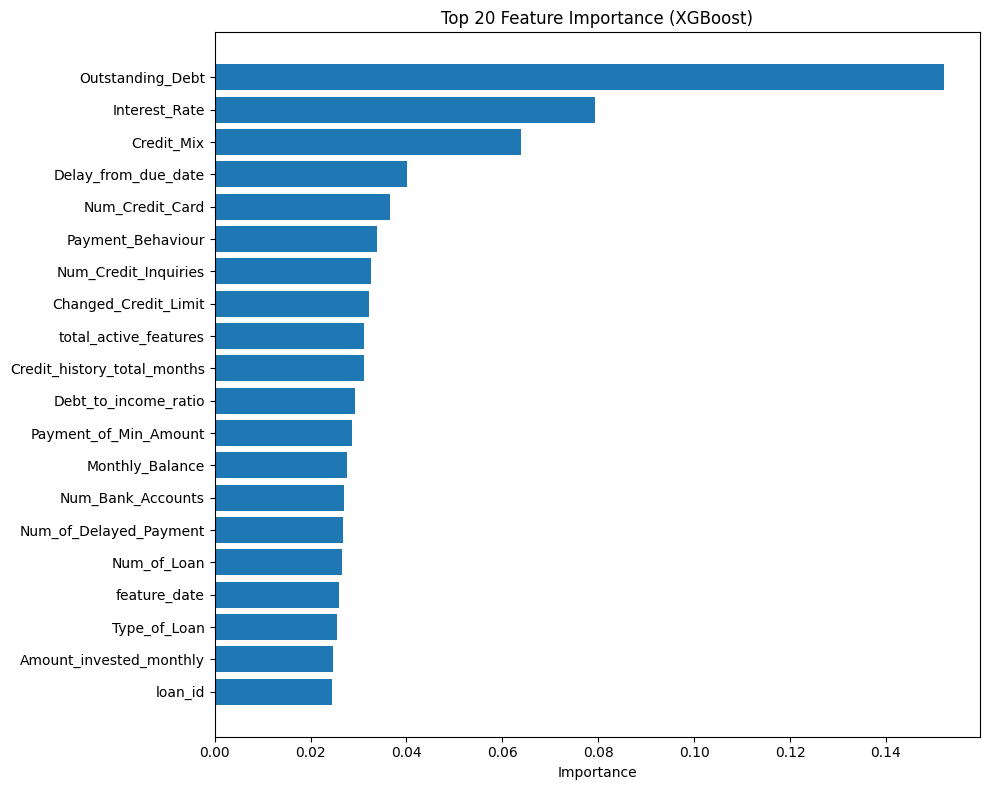


Number of features to reach 80% cumulative importance: 20/31

Top 20 features (80% importance):
['Outstanding_Debt', 'Interest_Rate', 'Credit_Mix', 'Delay_from_due_date', 'Num_Credit_Card', 'Payment_Behaviour', 'Num_Credit_Inquiries', 'Changed_Credit_Limit', 'total_active_features', 'Credit_history_total_months', 'Debt_to_income_ratio', 'Payment_of_Min_Amount', 'Monthly_Balance', 'Num_Bank_Accounts', 'Num_of_Delayed_Payment', 'Num_of_Loan', 'feature_date', 'Type_of_Loan', 'Amount_invested_monthly', 'loan_id']


In [22]:
# Get feature importance from best model
feature_importance = pd.DataFrame({
    'feature': preprocessors['feature_names'],
    'importance': best_model_retrained.feature_importances_
}).sort_values('importance', ascending=False)

print("\n" + "="*80)
print("FEATURE IMPORTANCE (Top 20)")
print("="*80)
print(feature_importance.head(20).to_string(index=False))

# Plot feature importance
plt.figure(figsize=(10, 8))
top_20 = feature_importance.head(20)
plt.barh(range(len(top_20)), top_20['importance'])
plt.yticks(range(len(top_20)), top_20['feature'])
plt.xlabel('Importance')
plt.title('Top 20 Feature Importance (XGBoost)')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

# Cumulative importance
feature_importance['cumulative_importance'] = feature_importance['importance'].cumsum() / feature_importance['importance'].sum()

# How many features to reach 80% importance?
n_features_80 = (feature_importance['cumulative_importance'] <= 0.80).sum()
print(f"\nNumber of features to reach 80% cumulative importance: {n_features_80}/{len(feature_importance)}")

# Show those features
print(f"\nTop {n_features_80} features (80% importance):")
print(feature_importance.head(n_features_80)['feature'].tolist())

## 11. ROC Curve and Precision-Recall Curve

In [ ]:
# Plot ROC curves for all datasets
fig, axes = plt.subplots(2, 2, figsize=(14, 12))
axes = axes.ravel()

datasets = [
    ('Train', y_train, y_train_proba_final),
    ('Validation', y_val, y_val_proba_final),
    ('Test', y_test, y_test_proba_final),
    ('OOT', y_oot, y_oot_proba_final)
]

for idx, (name, y_true, y_proba) in enumerate(datasets):
    fpr, tpr, _ = roc_curve(y_true, y_proba)
    auc = roc_auc_score(y_true, y_proba)
    
    axes[idx].plot(fpr, tpr, label=f'ROC (AUC = {auc:.4f})', linewidth=2)
    axes[idx].plot([0, 1], [0, 1], 'k--', label='Random')
    axes[idx].set_xlabel('False Positive Rate')
    axes[idx].set_ylabel('True Positive Rate')
    axes[idx].set_title(f'ROC Curve - {name}')
    axes[idx].legend()
    axes[idx].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [ ]:
# Plot Precision-Recall curves for all datasets
fig, axes = plt.subplots(2, 2, figsize=(14, 12))
axes = axes.ravel()

for idx, (name, y_true, y_proba) in enumerate(datasets):
    precision, recall, _ = precision_recall_curve(y_true, y_proba)
    
    axes[idx].plot(recall, precision, linewidth=2)
    axes[idx].set_xlabel('Recall')
    axes[idx].set_ylabel('Precision')
    axes[idx].set_title(f'Precision-Recall Curve - {name}')
    axes[idx].grid(True, alpha=0.3)
    
    # Add baseline (random classifier)
    baseline = y_true.sum() / len(y_true)
    axes[idx].axhline(y=baseline, color='k', linestyle='--', label=f'Baseline ({baseline:.3f})')
    axes[idx].legend()

plt.tight_layout()
plt.show()

## 12. Save Model and Artifacts

In [ ]:
# # Create models directory
# import os
# os.makedirs('/app/models', exist_ok=True)

# # Save final model
# model_path = '/app/models/xgboost_credit_default_model.pkl'
# joblib.dump(best_model_retrained, model_path)
# print(f"Model saved to: {model_path}")

# # Save preprocessors
# preprocessor_path = '/app/models/preprocessors.pkl'
# joblib.dump(preprocessors, preprocessor_path)
# print(f"Preprocessors saved to: {preprocessor_path}")

# # Save feature importance
# feature_importance_path = '/app/models/feature_importance.csv'
# feature_importance.to_csv(feature_importance_path, index=False)
# print(f"Feature importance saved to: {feature_importance_path}")

# # Save model metadata
# metadata = {
#     'model_type': 'XGBoost',
#     'training_date': str(datetime.now()),
#     'train_size': len(X_train),
#     'val_size': len(X_val),
#     'test_size': len(X_test),
#     'oot_size': len(X_oot),
#     'n_features': len(preprocessors['feature_names']),
#     'best_params': random_search.best_params_,
#     'scale_pos_weight': scale_pos_weight,
#     'train_auc': roc_auc_score(y_train, y_train_proba_final),
#     'val_auc': roc_auc_score(y_val, y_val_proba_final),
#     'test_auc': roc_auc_score(y_test, y_test_proba_final),
#     'oot_auc': roc_auc_score(y_oot, y_oot_proba_final),
#     'train_f1': f1_score(y_train, y_train_pred_final),
#     'val_f1': f1_score(y_val, y_val_pred_final),
#     'test_f1': f1_score(y_test, y_test_pred_final),
#     'oot_f1': f1_score(y_oot, y_oot_pred_final)
# }

# metadata_path = '/app/models/model_metadata.pkl'
# joblib.dump(metadata, metadata_path)
# print(f"Model metadata saved to: {metadata_path}")

# print("\n" + "="*80)
# print("MODEL TRAINING COMPLETE!")
# print("="*80)
# print(f"\nFinal Model Performance:")
# print(f"  Test AUC: {metadata['test_auc']:.4f}")
# print(f"  Test F1: {metadata['test_f1']:.4f}")
# print(f"  OOT AUC: {metadata['oot_auc']:.4f}")
# print(f"  OOT F1: {metadata['oot_f1']:.4f}")